In [ ]:
# Task 1: implement an LSTM model to predict the next word of a sentence.

In [1]:
import nltk
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


True

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from nltk.corpus import gutenberg
from nltk.tokenize import word_tokenize
import string
import random

# Download and sanitize the dataset
corpus = gutenberg.raw('austen-sense.txt')
# stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
corpus = ''.join([c for c in corpus if c not in punctuations])
# corpus = ' '.join([word for word in corpus.split() if word.lower() not in stop_words])
corpus = corpus.lower()


In [ ]:
corpus

'sense and sensibility by jane austen 1811\n\nchapter 1\n\n\nthe family of dashwood had long been settled in sussex\ntheir estate was large and their residence was at norland park\nin the centre of their property where for many generations\nthey had lived in so respectable a manner as to engage\nthe general good opinion of their surrounding acquaintance\nthe late owner of this estate was a single man who lived\nto a very advanced age and who for many years of his life\nhad a constant companion and housekeeper in his sister\nbut her death which happened ten years before his own\nproduced a great alteration in his home for to supply\nher loss he invited and received into his house the family\nof his nephew mr henry dashwood the legal inheritor\nof the norland estate and the person to whom he intended\nto bequeath it  in the society of his nephew and niece\nand their children the old gentlemans days were\ncomfortably spent  his attachment to them all increased\nthe constant attention of m

In [3]:
# Tokenize the corpus
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokens = tokenizer.tokenize(corpus)
# Generate 6-gram dataset
# tokens = word_tokenize(corpus)
vocab_size = len(set(tokens))
word_to_index = {word: i for i, word in enumerate(set(tokens))}
index_to_word = {i: word for i, word in enumerate(set(tokens))}
n_gram = 6
input_sequences = []
output_words = []
for i in range(n_gram, len(tokens)):
    sequence = tokens[i-n_gram:i]
    input_sequences.append([word_to_index[word] for word in sequence[:-1]])
    output_words.append(word_to_index[sequence[-1]])

In [5]:
class NgramDataset(Dataset):
    def __init__(self, input_sequences, output_words):
        self.input_sequences = input_sequences
        self.output_words = output_words

    def __len__(self):
        return len(self.input_sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.input_sequences[idx]), torch.tensor(self.output_words[idx])

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_seq):
        embedded = self.embedding(input_seq)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Set the hyperparameters
embedding_dim = 100
hidden_dim = 256
learning_rate = 0.001
batch_size = 256
num_epochs = 50

In [6]:
# Initialize the model and the data loader
model = LSTMModel(vocab_size, embedding_dim, hidden_dim)
dataset = NgramDataset(input_sequences, output_words)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)

# Train the model
loss_values = []
for epoch in range(num_epochs):
    for i, (input_seq, output_word) in enumerate(dataloader):
        optimizer.zero_grad()
        output = model(input_seq)
        loss = criterion(output, output_word)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.item()))
    loss_values.append(loss.item())


Epoch [1/50], Step [1/463], Loss: 8.9074
Epoch [2/50], Step [1/463], Loss: 5.8075
Epoch [3/50], Step [1/463], Loss: 5.1691
Epoch [4/50], Step [1/463], Loss: 4.6902
Epoch [5/50], Step [1/463], Loss: 4.5619
Epoch [6/50], Step [1/463], Loss: 4.1155
Epoch [7/50], Step [1/463], Loss: 4.0902
Epoch [8/50], Step [1/463], Loss: 3.7495
Epoch [9/50], Step [1/463], Loss: 3.4090
Epoch [10/50], Step [1/463], Loss: 3.0094
Epoch [11/50], Step [1/463], Loss: 2.7308
Epoch [12/50], Step [1/463], Loss: 2.4335
Epoch [13/50], Step [1/463], Loss: 2.5731
Epoch [14/50], Step [1/463], Loss: 2.0833
Epoch [15/50], Step [1/463], Loss: 1.7918
Epoch [16/50], Step [1/463], Loss: 1.8415
Epoch [17/50], Step [1/463], Loss: 1.7124
Epoch [18/50], Step [1/463], Loss: 1.4464
Epoch [19/50], Step [1/463], Loss: 1.3684
Epoch [20/50], Step [1/463], Loss: 1.2745
Epoch [21/50], Step [1/463], Loss: 1.1788
Epoch [22/50], Step [1/463], Loss: 0.9720
Epoch [23/50], Step [1/463], Loss: 0.8909
Epoch [24/50], Step [1/463], Loss: 0.7719
E

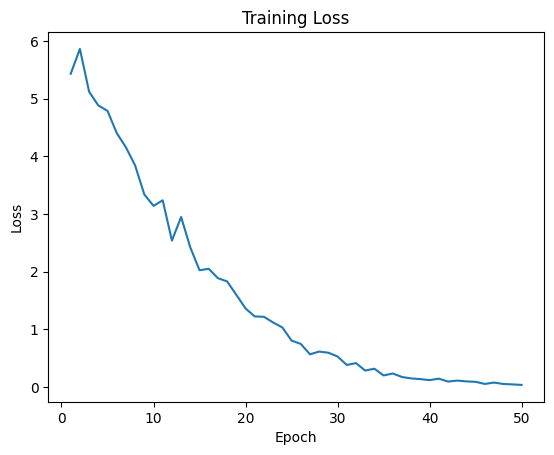

In [7]:

# Plot the loss values
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [8]:
# Set the model to evaluation mode
model.eval()

# Initialize the input sequence with the start phrase
input_seq = ['his', 'natural', 'shyness', 'was', 'overcome']

# Generate 100 words
for i in range(100):
    # Convert the input sequence to indices
    input_idx = [word_to_index[word] for word in input_seq]
    
    # Convert the indices to a PyTorch tensor
    input_tensor = torch.tensor(input_idx).unsqueeze(0)
    
    # Predict the next word
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_idx = torch.max(output, dim=1)
    
    # Convert the predicted index to a word
    predicted_word = index_to_word[predicted_idx.item()]
    
    # Add the predicted word to the input sequence
    input_seq.append(predicted_word)
    
    # Remove the first word from the input sequence to keep the sequence length at 5
    # input_seq.pop(0)
    
    # Print the predicted word
    print(predicted_word, end=' ')


his own room she took his welcome his assistance an absence pleasure she was equally his with his lady he was equally she was she turned round she with every one again she they should be a ill could not enter well before her let us wonder before mr palmer is not i believe he will he is very well worth if he is but he says he he is he to her her as a reply to the beginning to her feelings if not merely a of his countenance from every charge at ease at his emotion on their 

In [ ]:
# References: https://www.kaggle.com/code/ysthehurricane/next-word-prediction-bi-lstm-tutorial-easy-way ,
# https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/ ,
# https://thecleverprogrammer.com/2020/07/20/next-word-prediction-model/